In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import glob
from scipy.signal import convolve2d
%matplotlib inline

In [2]:
filepath = '/home/hasitha/Desktop/data/tescan_high/'
filename = 'recon_zoom_'

In [3]:
def image_normalization(img, L):
    """
    img: np.ndarray:
    L  : power of 2
    """
    _min, _max = img.min(), img.max()
    img = ((img-_min)/(_max-_min)*(L-1)).astype(np.uint8)
    return img

In [4]:
def image_histogram(img, L, disp=False):
    img = image_normalization(img, L)
    out = np.zeros(L)
    for i in np.arange(L):
        out[i] = np.sum(img==i)
    if disp:
        plt.figure(figsize=(8,8))
        plt.bar(np.arange(L), out)
        plt.title('image histogram, L = {}'.format(L))
        plt.show()
    return out

In [5]:
# this does not give better result, do not use it
def histogram_equalization(img, L, disp=False):
    img = image_normalization(img, L)
    hist = image_histogram(img, L)
    mapping = np.zeros(L)
    for i in np.arange(L):
        mapping[i] = int((L-1)*np.sum(hist[:i+1]))
    mapper = np.vectorize(lambda x: mapping[x])
    out = mapper(img)
    out = image_normalization(out, L)
    
    if disp:
        plt.figure(figsize=(8,8))
        plt.imshow(out, plt.cm.gray)
        plt.title('image after equalization')
        plt.show()
    return out

In [6]:
def gaussian_kernel(size, sigma=None):
    assert size%2 == 1 and size > 0, 'size must be odd positive integer' 
    if sigma == None:
        sigma = size // 6
    center = size//2
    kernel = np.zeros((size, size))
    for i in np.arange(size):
        for j in np.arange(size):
            diff2 = (i-center)**2 + (j-center)**2
            kernel[i,j] = np.exp(-diff2/sigma**2/2)
    out = kernel/np.sum(kernel)
    return out

In [7]:
def unsharp_mask(imgs, size, sigma, K, N):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    sharpened = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img    = image_normalization(img, 256)
        kernel = gaussian_kernel(size, sigma)
        blur   = convolve2d(img, kernel, mode='same', boundary='symm')
        mask   = img - blur
        mask   = image_normalization(mask, K)
        out    = img + N*mask
        sharpened[i,:,:] = image_normalization(out, 256)
    return sharpened

In [8]:
def image_binary(imgs):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    binaries = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img = image_normalization(img, 256)
        hist = image_histogram(img,256,True)
        sorted_hist = np.argsort(hist)
        print(sorted_hist[::-1][:5])
        hist[hist==0] = np.inf
        clf = np.argmin(hist[70:100])+70
        print("the {}-th image, has min {}".format(i,clf))
        binary = img > clf
        binaries[i,:,:] = binary
    return binaries

In [12]:
full_img = np.zeros((400,400,400))
for i in np.arange(400):
    file = filepath + filename + '{:05d}'.format(i+800)+'.tif'
    img = tif.imread(file)
    full_img[i] = img[550:950,550:950]
    
for i in np.arange(400):
    full_img[i] = image_normalization(full_img[i],256)

In [9]:
"""
mask = np.zeros((400,400))
for i in np.arange(400):
    for j in np.arange(400):
        mask[i,j] = -1e10 if (i-200)**2 + (j-200)**2 > 200**2 else 0
        
full_img = np.zeros((1200, 400, 400))
for i in np.arange(1200):
    file = filepath + filename + '{:05d}'.format(i+200)+'.tif'
    img  = tif.imread(file)
    #print(img.shape)
    full_img[i] = img[550:950,550:950] + mask

full_img[full_img < 0] = 0

for i in np.arange(1200):
    full_img[i] = image_normalization(full_img[i], 256)
"""

"\nmask = np.zeros((400,400))\nfor i in np.arange(400):\n    for j in np.arange(400):\n        mask[i,j] = -1e10 if (i-200)**2 + (j-200)**2 > 200**2 else 0\n        \nfull_img = np.zeros((1200, 400, 400))\nfor i in np.arange(1200):\n    file = filepath + filename + '{:05d}'.format(i+200)+'.tif'\n    img  = tif.imread(file)\n    #print(img.shape)\n    full_img[i] = img[550:950,550:950] + mask\n\nfull_img[full_img < 0] = 0\n\nfor i in np.arange(1200):\n    full_img[i] = image_normalization(full_img[i], 256)\n"

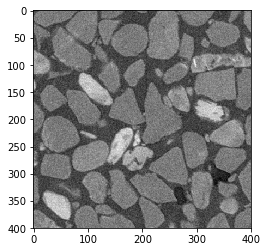

In [13]:
plt.imshow(full_img[20],cmap='gray')

In [14]:
full_img.shape

(400, 400, 400)

In [15]:
from skimage.restoration import denoise_nl_means, estimate_sigma

In [16]:
for i in np.arange(i):
    sigma_est = np.mean(estimate_sigma(full_img[i], multichannel=False))
    full_img[i] = denoise_nl_means(full_img[i], h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=6, multichannel=False)

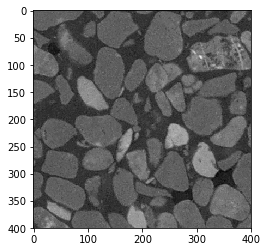

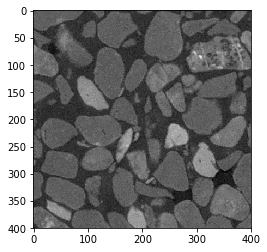

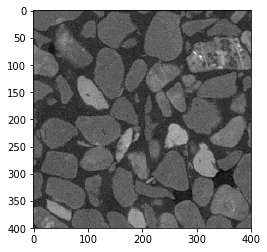

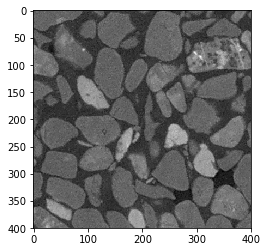

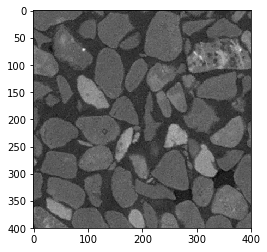

In [17]:
for i in np.arange(5):
    plt.imshow(full_img[i], plt.cm.gray)
    plt.show()

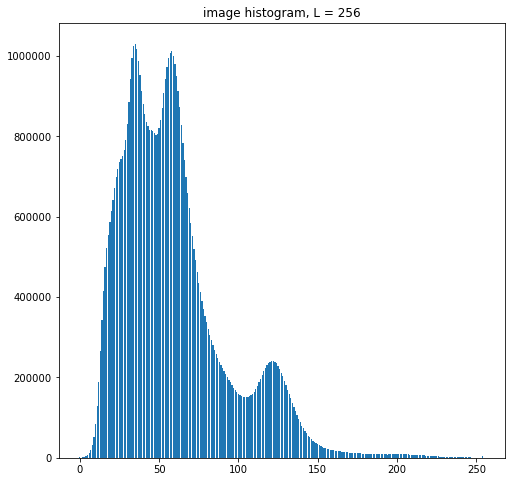

In [18]:
hist = image_histogram(full_img,256,True)

In [17]:
def image_binary(imgs):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    binaries = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img = image_normalization(img, 256)
        hist = image_histogram(img,256,True)
        sorted_hist = np.argsort(hist)[::-1]
        #int(sorted_hist)
        mark1 = sorted_hist[1]
        mark2 = 0
        ii = 1
        while True:
            sh = 15 if ii < 10 else 20
            if sorted_hist[ii]-sorted_hist[ii+1] > sh:
                mark2 = sorted_hist[ii+1]
                break
            else:
                ii += 1
        #print('mark1 = {}, mark2 = {}'.format(mark1, mark2))
        hist[hist==0] = np.inf
        clf = np.argmin(hist[mark2:mark1])+mark2
        #print("the {}-th image, has min {}".format(i,clf))
        binary = img > clf
        binaries[i,:,:] = binary
    return binaries

In [12]:
def image_binary(imgs):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    binaries = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img = image_normalization(img, 256)
        clf = 85
        binary = img > clf
        binaries[i,:,:] = binary
    return binaries

In [77]:
binary = image_binary(full_img)

In [78]:
binary.shape

(1200, 400, 400)

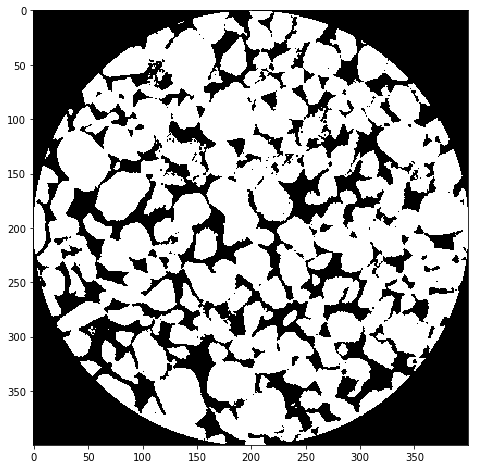

In [79]:
plt.figure(figsize=(8,8))
plt.imshow(binary[20], plt.cm.gray)

In [81]:
clf = 85
binary = full_img > clf

In [82]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'gray_grenoble.tif', binary)

In [85]:
type(binary[0,0,0])

numpy.bool_

In [11]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'gray_level.tif',binary)

NameError: name 'binary' is not defined

In [12]:
import spam.label
from skimage.restoration import denoise_nl_means, estimate_sigma

	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.


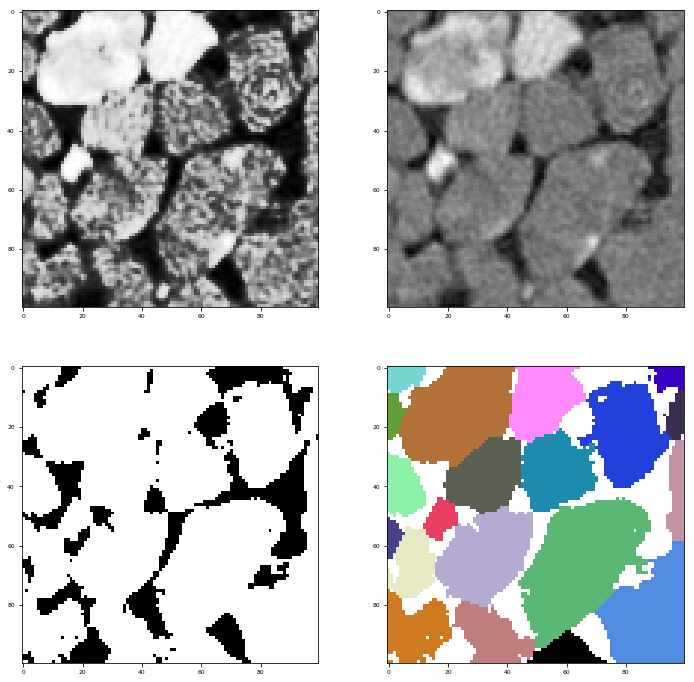

In [33]:
idx = 48
clf = 50
sigma_est = np.mean(estimate_sigma(full_img[idx], multichannel=False))
nlm = denoise_nl_means(full_img[idx], h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=6, multichannel=False)
binary1 = full_img[idx] > clf
lab1 = spam.label.watershed(binary1)
histeq = histogram_equalization(nlm, 256, False)
binary2 = histeq > clf
lab2 = spam.label.watershed(binary2, verbose=True)
#hist = image_histogram(nlm, 256, True)
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(histeq, plt.cm.gray)
plt.subplot(2,2,2)
plt.imshow(full_img[idx], plt.cm.gray)
plt.subplot(2,2,3)
plt.imshow(binary2, plt.cm.gray)
plt.subplot(2,2,4)
plt.imshow(lab2, cmap=spam.label.randomCmap)
#plt.subplot(3,2,5)
#plt.imshow(binary2, plt.cm.gray)
#plt.subplot(3,2,6)
#plt.imshow(lab2, cmap=spam.label.randomCmap)
plt.show()